<a href="https://colab.research.google.com/github/iMan0405/Portfolio_DT_vs_AI/blob/main/Load_video_data_for_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kutubxonlarni yuklab olish va o'rnatish

In [2]:
!pip install -U "tensorflow>=2.10.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [3]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.2-py3-none-any.whl size=7890 sha256=6bb8d5a620c3351bd53b82be91c63762447d82469cb460a6a6dd610c46d04587
  Stored in directory: /root/.cache/pip/wheels/f2/71/f9/c650cc34039d772da8b040ed447b6b5f5de9abc38d88073fa1
Successfully built remotezip
  Preparing metadata (setup.py) ... done


In [4]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

In [5]:
URL = "https://storage.googleapis.com/thumos14_files/UCF101_videos.zip"

In [6]:
def list_files_from_zip_url(zip_url):
    files = []
    with rz.RemoteZip(zip_url) as zip:
        for zip_info in zip.infolist():
            files.append(zip_info.filename)
    return files

In [7]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [8]:
def get_class(fname):
    return fname.split('_')[-3]

In [9]:
def get_files_per_class(files):
    files_for_class = collections.defaultdict(list)
    for fname in files:
        class_name = get_class(fname)
        files_for_class[class_name].append(fname)
    return files_for_class

In [10]:
NUM_CLASSES = 10
FILES_PER_CLASS = 50

In [11]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [12]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


In [13]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
    files_subset = dict()
    for class_name in classes:
        class_files = files_for_class[class_name]
        files_subset[class_name] = class_files[:files_per_class]
    return files_subset

In [14]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

In [15]:
def download_from_zip(zip_url, to_dir, file_names):
    with rz.RemoteZip(zip_url) as zip:
        for fn in tqdm.tqdm(file_names):
            class_name = get_class(fn)
            zip.extract(fn, str(to_dir / class_name))
            unzipped_file = to_dir / class_name / fn

            fn = pathlib.Path(fn).parts[-1]
            output_file = to_dir / class_name / fn
            unzipped_file.rename(output_file)

In [16]:
def split_class_lists(files_for_class, count):
    split_files = []
    remainder = {}
    for cls in files_for_class:
        split_files.extend(files_for_class[cls][:count])
        remainder[cls] = files_for_class[cls][count:]
    return split_files, remainder

In [17]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):
    files = list_files_from_zip_url(zip_url)
    for f in files:
        path = os.path.normpath(f)
        tokens = path.split(os.sep)
        if len(tokens) <= 2:
            files.remove(f)
    files_for_class = get_files_per_class(files)
    classes = list(files_for_class.keys())[:num_classes]

    for cls in classes:
        random.shuffle(files_for_class[cls])
    files_for_class = {x: files_for_class[x] for x in classes}

    dirs = {}
    for split_name, split_count in splits.items():
        print(split_name, ":")
        split_dir = download_dir / split_name
        split_files, files_for_class = split_class_lists(files_for_class, split_count)
        download_from_zip(zip_url, split_dir, split_files)
        dirs[split_name] = split_dir
    return dirs

In [18]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train":30, "val":10, "test":10},
                                       download_dir = download_dir)

train :


100%|██████████| 300/300 [01:13<00:00,  4.08it/s]


val :


100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


test :


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


In [19]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


In [20]:
!find ./UCF101_subset

./UCF101_subset
./UCF101_subset/train
./UCF101_subset/train/ApplyEyeMakeup
./UCF101_subset/train/ApplyEyeMakeup/UCF101
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c06.avi
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g24_c06.avi
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g21_c04.avi
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g19_c02.avi
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g19_c04.avi
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c04.avi
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c01.avi
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g06_c01.avi
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g14_c01.avi
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g13_c03.avi
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g24_c02.avi
./UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g23_c04.avi
./UCF101_subset/train/A

In [21]:
def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [22]:
def frames_from_video_file(video_path, n_frames, output_size = (224, 224), frame_step = 15):
    result = []
    src = cv2.VideoCapture(str(video_path))
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    need_length = 1+ (n_frames - 1) * frame_step
    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

### Video ma'lumotlarni vizualizatsiya qilish

In [23]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  26.0M      0  0:00:02  0:00:02 --:--:-- 26.0M


In [24]:
video_path = "End_of_a_jam.ogv"

In [25]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(10, 224, 224, 3)

In [26]:
def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=10)
    return embed.embed_file('./animation.gif')


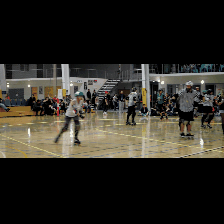

In [27]:
to_gif(sample_video)


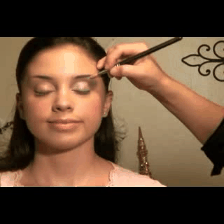

In [28]:
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

In [36]:
class FrameGenerator:
    def __init__(self, path, n_frames, training = False):
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name]
            yield video_frames, label

In [37]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)
frames, label = next(fg())
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 0


In [38]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)

In [39]:
for frames, labels in train_ds.take(10):
    print(labels)

tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)


In [40]:
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [41]:
train_frames, train_labels = next(iter(train_ds))
print(f"Shape of training set of frames: {train_frames.shape}")
print(f"Shape of training labels: {train_labels.shape}")

val_frames, val_labels = next(iter(val_ds))
print(f"Shape of validation set of frames: {val_frames.shape}")
print(f"Shape of validation labels: {val_labels.shape}")

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [43]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f"Shape of training set of frames: {train_frames.shape}")
print(f"Shape of training labels: {train_labels.shape}")

val_frames, val_labels = next(iter(val_ds))
print(f"Shape of validation set of frames: {val_frames.shape}")
print(f"Shape of validation labels: {val_labels.shape}")

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


In [44]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds,
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
150/150 [==============================] - 29s 102ms/step - loss: 1.1100 - accuracy: 0.7600 - val_loss: 0.5184 - val_accuracy: 0.9300
Epoch 2/10
150/150 [==============================] - 9s 63ms/step - loss: 0.3080 - accuracy: 0.9667 - val_loss: 0.3051 - val_accuracy: 0.9600
Epoch 3/10
150/150 [==============================] - 9s 58ms/step - loss: 0.1714 - accuracy: 0.9933 - val_loss: 0.2282 - val_accuracy: 0.9700
Epoch 4/10
150/150 [==============================] - 9s 59ms/step - loss: 0.1102 - accuracy: 0.9967 - val_loss: 0.1929 - val_accuracy: 0.9600
Epoch 5/10
150/150 [==============================] - 9s 60ms/step - loss: 0.0804 - accuracy: 0.9967 - val_loss: 0.1617 - val_accuracy: 0.9700
Epoch 6/10
150/150 [==============================] - 9s 62ms/step - loss: 0.0575 - accuracy: 0.9967 - val_loss: 0.1444 - val_accuracy: 0.9700
Epoch 7/10
150/150 [==============================] - 9s 58ms/step - loss: 